# Getting started

## An introduction to momepy

Momepy is a library for quantitative analysis of urban form - urban morphometrics. It is built on top of [GeoPandas](http://geopandas.org), [PySAL](http://pysal.org) and [networkX](http://networkx.github.io).

Some of the functionality that momepy offers:

- Measuring [dimensions](https://docs.momepy.org/en/latest/api.html#dimension) of morphological elements, their parts, and aggregated structures.
- Quantifying [shapes](https://docs.momepy.org/en/latest/api.html#shape) of geometries representing a wide range of morphological features.
- Capturing [spatial distribution](https://docs.momepy.org/en/latest/api.html#spatial-distribution) of elements of one kind as well as relationships between different kinds.
- Computing density and other types of [intensity](https://docs.momepy.org/en/latest/api.html#intensity) characters.
- Calculating [diversity](https://docs.momepy.org/en/latest/api.html#diversity) of various aspects of urban form.
- Capturing [connectivity](https://docs.momepy.org/en/latest/api.html#graph) of urban street networks
- Generating relational [elements](https://docs.momepy.org/en/latest/api.html#elements) of urban form (e.g. morphological tessellation)

Momepy aims to provide a wide range of tools for a systematic and exhaustive analysis of urban form. It can work with a wide range of elements, while focused on building footprints and street networks.

## Installation

Momepy can be easily installed using conda from `conda-forge`. For detailed installation instructions, please refer to the [documentation](https://docs.momepy.org/en/latest/install.html).

In [ ]:
conda install momepy -c conda-forge

### Dependencies

To run all examples in this notebook, you will need some optional dependencies. `matplotlib`, `descartes` and `mapclassify` (or `pysal`) for plotting (these are GeoPandas dependencies) and `osmnx` to download data from OpenStreetMap. You can install all using the following commands: 

In [ ]:
conda install matplotlib descartes osmnx -c conda-forge
pip install mapclassify

## Simple examples

Here are simple examples using embedded `bubenec` dataset (part of the Bubeneč neighborhood in Prague).

In [1]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt

Morphometric analysis using momepy usually starts with GeoPandas GeoDataFrame containing morphological elements. In this case, we will begin with buildings represented by their footprints. 

We have imported `momepy`, `geopandas` to handle the spatial data, and `matplotlib` to get a bit more control over plotting. To load `bubenec` data, we need to get retrieve correct path using `momepy.datasets.get_path("bubenec")`. The dataset itself is a GeoPackage with more layers, and now we want `buildings`.

In [2]:
buildings = gpd.read_file(momepy.datasets.get_path('bubenec'),
                          layer='buildings')

**Note:** To see the code used to plot the map, click on the plus button in the top right corner.

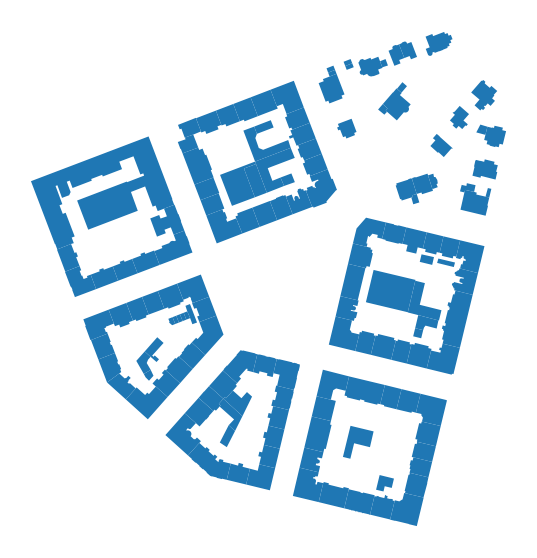

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax)
ax.set_axis_off()
plt.show()

Momepy uses classes for each measurable character, which stores the resulting values but also original input and all parameters used for the computation. The only exception is the [`graph` module](graph/graph). To illustrate how momepy classes work, we can try to measure a few simple characters.

### Area

`momepy.Area` measures the area of polygon geometry. It is a simple wrapper around `gdf.geoemtry.area`, included in momepy for consistency. `momepy.Area` does not need any attributes apart from source GeoDataFrame.

In [6]:
blg_area = momepy.Area(buildings)
buildings['area'] = blg_area.series

Tip: `.series` will give you resulting Pandas Series in most of the cases (unless there are more resulting Series).

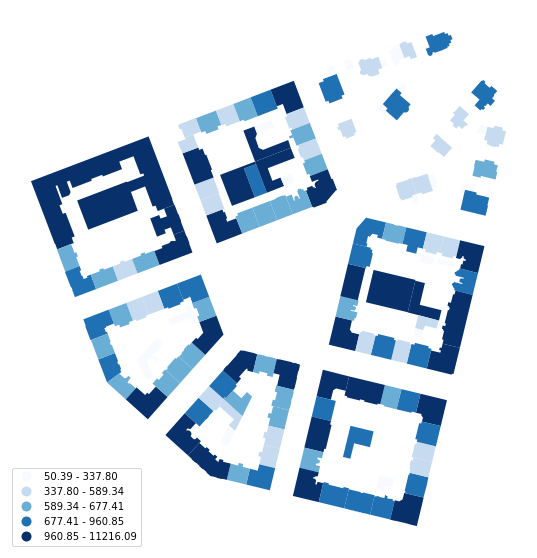

In [20]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot('area', ax=ax, legend=True, scheme='quantiles', cmap='Blues', legend_kwds={'loc': 'lower left'})
ax.set_axis_off()
plt.show()

Above, we have calculated the area of each building and then extracted resulting values (pandas.Series) to save them as a new column of `buildings`. You can also get original GeoDataFrame as documented in the [API](https://docs.momepy.org/en/latest/generated/momepy.Area.html#momepy.Area):

In [76]:
blg_area.gdf.head()

,uID,geometry,area
0,1,"POLYGON ((1603599.221193187 6464369.815517657,...",728.557495
1,2,"POLYGON ((1603042.87977405 6464261.497778866, ...",11216.093578
2,3,"POLYGON ((1603044.649753952 6464178.034552199,...",641.059515
3,4,"POLYGON ((1603036.556826973 6464141.466502897,...",903.746689
4,5,"POLYGON ((1603082.38706133 6464142.02187786, 1...",641.629131


### Equivalent rectangular index

`momepy.EquivalentRectangularIndex` is an example of a morphometric character capturing the shape of each object. It can be calculated in an analogical way as the area above:

In [22]:
blg_ERI = momepy.EquivalentRectangularIndex(buildings)

100%|██████████| 144/144 [00:00<00:00, 912.11it/s]


To calculate the equivalent rectangular index, we need to know the area and perimeter of each polygon. While momepy can compute both automatically, we might want to save time passing already computed areas directly:

In [ ]:
blg_ERI = momepy.EquivalentRectangularIndex(buildings, areas='area')
buildings['eri'] = blg_ERI.series

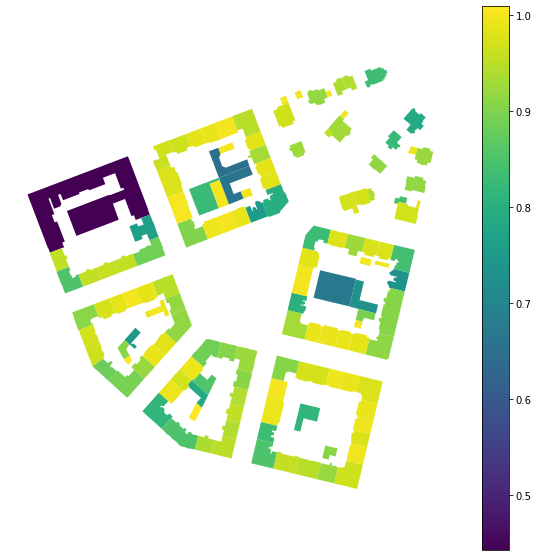

In [23]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot('eri', ax=ax, legend=True)
ax.set_axis_off()
plt.show()

Apart from resulting values stored in `blg_ERI.eri` we can also see all values used for computation, including perimeters we have not passed above.

In [67]:
blg_ERI.areas.head()

0      728.557495
1    11216.093578
2      641.059515
3      903.746689
4      641.629131
Name: mm_a, dtype: float64

In [68]:
blg_ERI.perimeters.head()

0    137.186310
1    991.345770
2    107.488923
3    141.740042
4    107.158092
Name: mm_p, dtype: float64

## Capturing relation between different elements

Urban form is a complex entity that needs to be represented by multiple morphological elements, and we need to be able to describe the relationship between them. With the absence of plots for our `bubenec` case, we can use [morphological tessellation](elements/tessellation) as the smallest spatial division.

In [4]:
tessellation = gpd.read_file(momepy.datasets.get_path('bubenec'),
                             layer='tessellation')

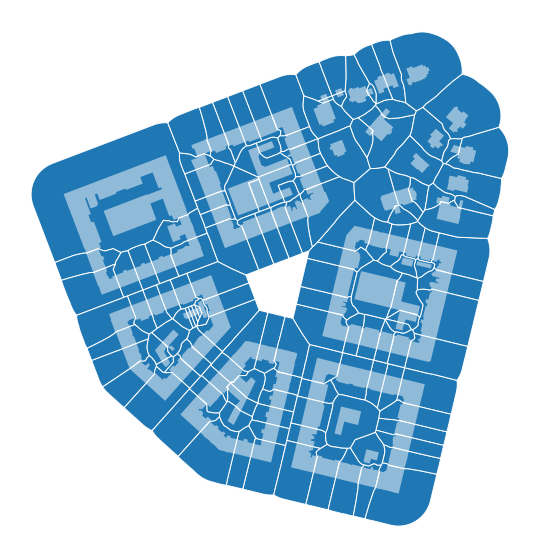

In [26]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor='white')
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()


### Coverage area ratio

Now we can calculate how big part of each tessellation cell is covered by a related building, using `momepy.AreaRatio`. Momepy classes usually accept any list-like object to be passed as values on top of a column name. Below we are passing Series to `left_areas` and column name to `right_areas`. Buildings have the same `uID` as related tessellation cells, which is used to link both together (see [Data Structure](data_structure)).

In [7]:
coverage = momepy.AreaRatio(tessellation, buildings, left_areas=tessellation.area,
                            right_areas='area', unique_id='uID')
tessellation['CAR'] = coverage.series

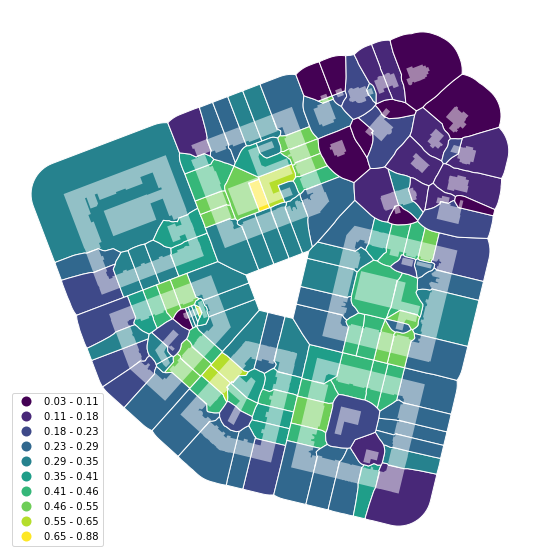

In [34]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot('CAR', ax=ax, edgecolor='white', legend=True, scheme='NaturalBreaks', k=10, legend_kwds={'loc': 'lower left'})
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

Finally, to cover the last of the essential elements, we import the street network. 

In [35]:
streets = gpd.read_file(momepy.datasets.get_path('bubenec'),
                        layer='streets')

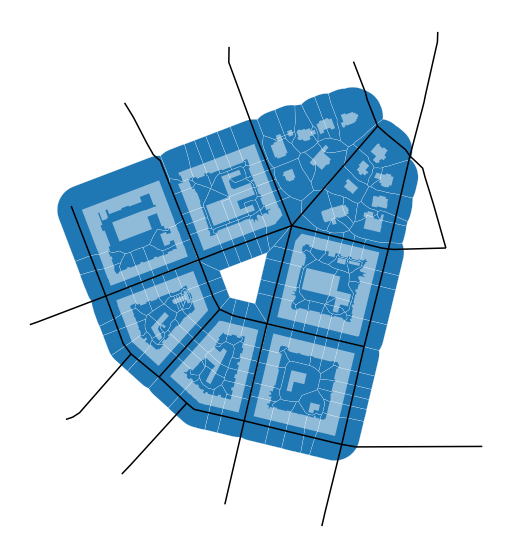

In [36]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor='white', linewidth=0.2)
buildings.plot(ax=ax, color='white', alpha=.5)
streets.plot(ax=ax, color='black')
ax.set_axis_off()
plt.show()


### Street Profile

`momepy.StreetProfile` captures the relations between the segments of the street network and buildings. 

In [40]:
profile = momepy.StreetProfile(streets, buildings)

100%|██████████| 35/35 [00:03<00:00,  9.56it/s]


We have now captured multiple characters of the street profile. As we did not specify building height (we do not know it for our data), we have widths (mean) - `profile.w`, standard deviation of widths (along the segment) - `profile.wd`,  and the degree of openness - `profile.o`.

`StreetProfile` measures several characters at the same time. Each of them is saved in its own Series, so `.series` would not work here.

In [41]:
streets['width'] = profile.w
streets['openness'] = profile.o

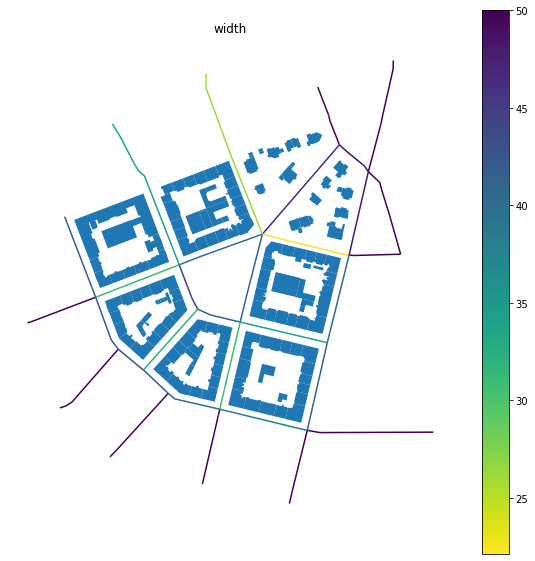

In [72]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax)
streets.plot('width', ax=ax, legend=True, cmap='viridis_r')
ax.set_axis_off()
ax.set_title('width')
plt.show()

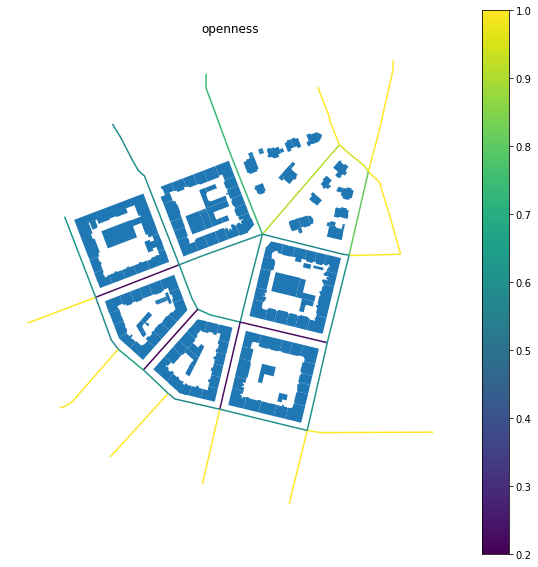

In [73]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax)
streets.plot('openness', ax=ax, legend=True)
ax.set_axis_off()
ax.set_title('openness')
plt.show()

## Using OpenStreetMap data

In some cases (based on the completeness of OSM), we can use OpenStreetMap data without the need to save them to file and read them via GeoPandas. We can use OSMnx to retrieve them directly. In this example, we will download the building footprint of Kahla in Germany and project it to projected CRS. Momepy expects that all GeoDataFrames have the same (projected) CRS.

In [54]:
import osmnx as ox

gdf = ox.footprints.footprints_from_place(place='Kahla, Germany')
gdf_projected = ox.project_gdf(gdf)

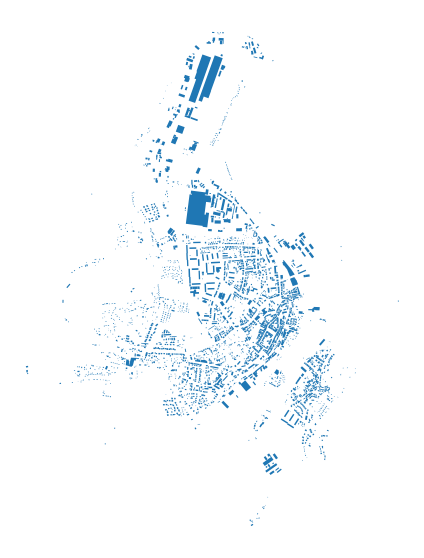

In [55]:
f, ax = plt.subplots(figsize=(10, 10))
gdf_projected.plot(ax=ax)
ax.set_axis_off()
plt.show()

Now we are in the same situation as we were above, and we can start our morphometric analysis as illustrated on the equivalent rectangular index below.

In [56]:
gdf_ERI = momepy.EquivalentRectangularIndex(gdf_projected)
gdf_projected['eri'] = gdf_ERI.series

100%|██████████| 2932/2932 [00:02<00:00, 1203.94it/s]


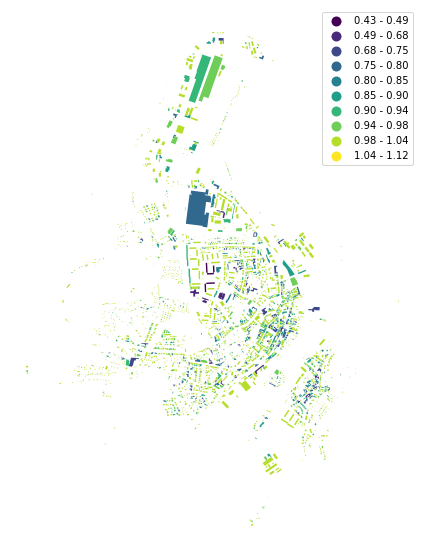

In [62]:
f, ax = plt.subplots(figsize=(10, 10))
gdf_projected.plot('eri', ax=ax, legend=True, scheme='NaturalBreaks', k=10)
ax.set_axis_off()
plt.show()

## Next steps

Now we have basic knowledge of what momepy is and how it works. It is time to [install](https://docs.momepy.org/en/latest/install.html) momepy (if you haven't done so yet) and browse the rest of this user guide to see more examples. Once done, head to the [API reference](https://docs.momepy.org/en/latest/api.html) to see the full extent of characters momepy can capture and find those you need for your research.